# Check segmentation made with Ilastik

- Loads registered data and probability outputs from Ilastik to visualize
- Thresholds probability outputs to produce binary cell masks for the three strains

In [4]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#next line is required for Napari
%gui qt

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd

#image viewer
import napari
from napari.utils.notebook_display import nbscreenshot

#out of memory computation
import dask.array as da
import dask_image.ndmorph as damorph

#path handling
import pathlib

#image processing packages

import skimage.filters as filters
from skimage.measure import label, regionprops_table
from skimage import morphology

#file handling
import h5py

#dask cash
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

## Set Paths and settings

In [5]:
#set path to registered file
# path_regestired_im = pathlib.Path("/Volumes/ScientificData/Users/Giulia(botgiu00)/Collaborations/Ashley/2023-04-11-agar-pad-processed/Registration_max_frames/")

# #set path to Ilastik output file
# path_segmented_im = pathlib.Path("/Volumes/ScientificData/Users/Giulia(botgiu00)/Collaborations/Ashley/2023-04-11-agar-pad-processed/Registration_max_frames/")

#set path to registered file
path_regestired_im = pathlib.Path("/Users/simonvanvliet/TempData/2023-04-11-agar-pad-processed/Registration_max_frames/")

#set path to Ilastik output file
path_segmented_im = pathlib.Path("/Users/simonvanvliet/TempData/2023-04-11-agar-pad-processed/Registration_max_frames/")

#set filenames
exp_name = "20230411"
pos_idx = 0

#specify the order of the strains in the Ilastik layers
idx_SA1 = 0 #SA1 is GFP strain
idx_SA2 = 1 #SA2 is RFP strain
idx_BG = 2
idx_PA = 3

## Load single position to check output 

In [6]:
#create metadata path and file names
metadata_path = pathlib.Path(f'./agarpad_{exp_name}.csv')
file_name_im = f"{exp_name}_reg_p{pos_idx:03d}.h5"
file_name_seg = f"{exp_name}_reg_p{pos_idx:03d}-images_Probabilities.h5"

#load metadata
df = pd.read_csv(metadata_path, index_col=0)
        
#load registered images
reg_im_file = h5py.File(path_regestired_im/file_name_im, 'r') #open 
chunk_size = (1, *reg_im_file['images'].shape[-3:])
reg_im = da.from_array(reg_im_file['images'], chunks=chunk_size)

#load segmented images
seg_im_file = h5py.File(path_segmented_im/file_name_seg, 'r') #open 
chunk_size = (1, 1,*reg_im_file['images'].shape[-2:])

seg_prob = da.from_array(seg_im_file['exported_data'], chunks=chunk_size)

#crop to max frame
max_frm = int(df.loc[f"pos{pos_idx:03d}","max_frame"]) if f"pos{pos_idx:03d}" in df.index else reg_im.shape[0]
reg_im = reg_im[:max_frm]       
seg_prob = seg_prob[:max_frm]       

condition = df.loc[f"pos{pos_idx:03d}","condition"] if f"pos{pos_idx:03d}" in df.index else ''

#convert to float if necessary
if seg_prob.dtype == 'uint8':
    seg_prob = seg_prob.astype('float32')/255

## Process Segmentation

---

### 1. Pre-process probability map using filters

As a first step probability maps are often processed using a Gaussian blur filter using a small (~1 pixel) size, to ensure that the probability maps are locally smooth. We will use scikit image [`filters.gaussion`](https://scikit-image.org/docs/stable/api/skimage.filters.html) to do this. 

Afterwards we inspect with Napari

In [7]:
#smooth probabilities
sigma = 1

p_SA1 = da.map_blocks(filters.gaussian, seg_prob[:,idx_SA1,:,:], sigma, channel_axis=0)
p_SA2 = da.map_blocks(filters.gaussian, seg_prob[:,idx_SA2,:,:], sigma, channel_axis=0)
p_PA = da.map_blocks(filters.gaussian, seg_prob[:,idx_PA,:,:], sigma, channel_axis=0)

### Check probability image with Napari

In [8]:
viewer = napari.view_image(reg_im,
            channel_axis=1,
            name=["red", "green", "phase"],
            colormap=["red", "green", "gray"])

#add probability layer to Napari Viewer
prop_layer1 = viewer.add_image(p_SA1, name='pSA1',colormap='gray')
prop_layer2 = viewer.add_image(p_SA2, name='pSA2',colormap='gray')
prop_layer3 = viewer.add_image(p_PA, name='pPA',colormap='gray')

napari.run()

----
### 2. Convert probability map to semantic segmentation using thresholding

Here we try to find a good threshold value to convert probability image to binary mask

In [9]:
#create array with all threshold values to rry, here we use 0,0.01,0.02,...,1
thresholds_to_try = np.linspace(0,1,101)

#convert the list of 3D stacks to a single 4D stack
SA1_stack = da.stack([p_SA1 > t for t in thresholds_to_try], axis=0)
SA2_stack = da.stack([p_SA2 > t for t in thresholds_to_try], axis=0)
PA_stack = da.stack([p_PA > t for t in thresholds_to_try], axis=0)


#add to viewer
mask_layer_int1 = viewer.add_image(SA1_stack, name='SA1 mask stack',colormap='gray')
mask_layer_int2 = viewer.add_image(SA2_stack, name='SA2 mask stack',colormap='gray')
mask_layer_int3 = viewer.add_image(PA_stack, name='PA mask stack',colormap='gray')

### Find threshold values

Try to find a threshold value to convert probability image to binary mask.

1. Select one of the mask layers (PA/SA1/SA1 mask)
2. Change opacity in top left control window
3. Change threshold value with bottom most slider (Note: the slider goes from 0-100 this corresponds to a threshold value of 0-1, i.e. divide slider position by 100)
4. Write down a threshold value that works well for all images, typically it should be between 0.5-0.7. 
5. If you cannot find a good threshold value, go back to Ilastik and improve training in the problematic areas

In [10]:
#nbscreenshot(viewer)

#### Fix Threshold values

If Ilastik training is done well, a fixed threshold of about 0.5 should generally work well.

Here we use this value, but you can change it below. Note: if the needed threshold deviates from the range 0.5-0.7 it's generally better to go back to Ilastik and train some more

In [11]:
#enter a manually chosen value for thresholds
tr_SA1 = 0.5
tr_SA2 = 0.5
tr_PA = 0.5

#### Apply thresholds

In [12]:
SA1_mask = p_SA1 > tr_SA1
SA2_mask = p_SA2 > tr_SA2
PA_mask = p_PA > tr_PA


#add to viewer
mask_layer_SA1 = viewer.add_image(SA1_mask, name='SA1 mask',colormap='red',opacity=0.3)
mask_layer_SA2 = viewer.add_image(SA2_mask, name='SA2 mask',colormap='green',opacity=0.3)
mask_layer_PA = viewer.add_image(PA_mask, name='PA mask',colormap='gray',opacity=0.3)

---

### 3. Merge cells in colonies into single mask

Here we merge cells that belong to same colony together using a morphological closing operation.

You have to adapt the `closing_radius` argument below for each species to make this work well.

Check the result in Napari and adapt the `closing_radius` if needed

In [13]:
closing_radius = 5

#create structuring element
disk = np.expand_dims(morphology.disk(closing_radius), axis=0)

SA1_mask_col = damorph.binary_closing(SA1_mask, disk)
SA2_mask_col = damorph.binary_closing(SA2_mask, disk)
PA_mask_col = damorph.binary_closing(PA_mask, disk)

#add mask to Napari
mask_layer_col1 = viewer.add_image(SA1_mask_col, name='SA1 mask colonies',colormap='red',opacity=0.3)
mask_layer_col2 = viewer.add_image(SA2_mask_col, name='SA2 mask colonies',colormap='green',opacity=0.3)
mask_layer_col3 = viewer.add_image(PA_mask_col, name='PA mask colonies',colormap='gray',opacity=0.3)

----
### 4. Clean up semantic segmentation using morphological operations

Now we do some basic clean up to remove small objects and fill holes.

You might need to adapt the `max_hole_area` and `min_cell_area` below, which are the maximum area of holes that will be filled (in pixels), and the 
minimum area of objects to keep (in pixels).

In [14]:
def clean_mask(mask, min_cell_area=20, max_hole_area=40):
    mask = da.map_blocks(morphology.remove_small_holes, mask, max_hole_area)
    mask = da.map_blocks(morphology.remove_small_objects, mask, min_cell_area)
    return mask

In [15]:
#clean up cell masks
SA1_mask_colcl = clean_mask(SA1_mask_col, min_cell_area=20, max_hole_area=100)
SA2_mask_colcl = clean_mask(SA2_mask_col, min_cell_area=20, max_hole_area=100)
PA_mask_colcl = clean_mask(PA_mask_col, min_cell_area=20, max_hole_area=100)

#add mask to Napari
mask_layer_clean1 = viewer.add_image(SA1_mask_colcl, name='SA1 mask cleaned',colormap='red',opacity=0.55)
mask_layer_clean2 = viewer.add_image(SA2_mask_colcl, name='SA2 mask cleaned',colormap='green',opacity=0.3)
mask_layer_clean3 = viewer.add_image(PA_mask_colcl, name='PA mask cleaned',colormap='gray',opacity=0.3)

---
### 5. Convert semantic segmentation into instance segmentation

Now we give each colony a unique number (corresponding to a unique color in Napari)

Check when colonies start to merge (i.e. when neighboring colors switch to having same color because they touch)

In [16]:
#convert binary markers into label markers:
SA1_labels = da.map_blocks(label, SA1_mask_colcl)
SA2_labels = da.map_blocks(label, SA2_mask_colcl)
PA_labels = da.map_blocks(label, PA_mask_colcl)


#add markers to Napari
nap_marker_labels1 = viewer.add_labels(SA1_labels, name='SA1 Labels')
nap_marker_labels2 = viewer.add_labels(SA2_labels, name='SA2 Labels')
nap_marker_labels3 = viewer.add_labels(PA_labels, name='PA Labels')

----
### 6. Extract Colony Properties

In [17]:
SA1_labels = SA1_labels.compute()
SA2_labels = SA2_labels.compute()
PA_labels = PA_labels.compute()

In [18]:
#function to process single frame  
def extract_prop_slice(label_im, prop_list, image=None, metadata=None):
    '''extract region properties from a single frame
    
    Parameters
    ----------
    label_im : dask array
        the label image
    prop_list : list
        list of properties to extract
    image : dask array
        fluorescent image to extract intensity properties from
    metadata : dict
        dictionary of metadata to add to the table
    
    Returns
    -------
    pandas.DataFrame
        table of region properties
    
    '''
    
    label_im = label_im.compute() if isinstance(label_im, da.Array) else label_im
    
    if image is None:
        rp_table = regionprops_table(label_im, properties=prop_list) 
    else:
        #regionprops need color channel to be at end
        image = da.moveaxis(image, 0, -1)
        rp_table = regionprops_table(label_im, intensity_image=image.compute(), properties=prop_list) 
    
    df = pd.DataFrame(rp_table)
    #add the time index
    if metadata is not None:
        for key, val in metadata.items():
            df[key] = val
    
    return df

In [19]:
#specify properties to extract 
prop_list = ['label', 
            'area', 'centroid', 
            'axis_major_length', 'axis_minor_length']

In [20]:

#loop over all frames
df_SA1 = pd.concat([extract_prop_slice(label, 
                                       prop_list, 
                                       metadata = {'frame':t, 'strain':'SA1','condition':condition}) 
                    for t, label in enumerate(SA1_labels)])

df_SA2 = pd.concat([extract_prop_slice(label, 
                                       prop_list, 
                                       metadata = {'frame':t, 'strain':'SA2','condition':condition}) 
                    for t, label in enumerate(SA2_labels)])

df_PA = pd.concat([extract_prop_slice(label, 
                                       prop_list, 
                                       metadata = {'frame':t, 'strain':'PA','condition':condition}) 
                    for t, label in enumerate(PA_labels)])

In [21]:
df = pd.concat([df_SA1, df_SA2, df_PA]).reset_index(drop=True)

---

### 7. Track Colonies

In [22]:
def track_colonies(df, direction='forward'):
    '''track colonies in a dataframe of region properties
            
    Parameters
    ----------
    df : pandas.DataFrame
        table of region properties
    direction : str, optional
        forward or backward tracking, by default 'forward'
    
    Returns
    -------
    pandas.DataFrame
        table of region properties with colony ids
    
    '''
    #add colony id to dataframe
    df = df.copy()
    df['colony_id']=-1

    #set col_idx for frame 0
    frm0 = df['frame']==0
    col_idx0 = np.arange(frm0.sum())
    df.loc[frm0, 'colony_id'] = col_idx0

    #forward tracking
    for frm in range(1, df['frame'].max()+1):
        col_idx_prev = df[df['frame']==frm-1]['colony_id'].values

        #calc distance between centroids
        x0 = df[df['frame']==frm-1]['centroid-0'].values
        y0 = df[df['frame']==frm-1]['centroid-1'].values

        x1 = df[df['frame']==frm]['centroid-0'].values
        y1 = df[df['frame']==frm]['centroid-1'].values

        if direction == 'forward':
            #forward tracking
            dx = np.atleast_2d(x0).T - np.atleast_2d(x1) #row is x0, col is x1
            dy = np.atleast_2d(y0).T - np.atleast_2d(y1) #row is y0, col is y1
        elif direction == 'backward':
            #backward tracking
            dx = np.atleast_2d(x1).T - np.atleast_2d(x0) #row is x1, col is x0
            dy = np.atleast_2d(y1).T - np.atleast_2d(y0) #row is y1, col is y0
        
        ds = np.sqrt(dx**2 + dy**2)

        #get column index of minimum distance between each cell in frame 0 and frame 1
        idx = np.argmin(ds, axis=1)

        #forward tracking
        if direction == 'forward':
            #init new col_idx
            col_idx_new = -1 * np.ones(np.sum(df['frame']==frm))
            
            #make sure each colony in frame t is only matched to one colony in frame t-1
            unique_idx = np.unique(idx)
            for id_new in unique_idx:
                if np.sum(idx==id_new) == 1: #unique match
                    id_old = np.where(idx==id_new)[0][0]
                    col_idx_new[id_new] = col_idx_prev[id_old]
        elif direction == 'backward':
            col_idx_new = col_idx_prev[idx]
        
        #assign new col_idx
        df.loc[df['frame']==frm, 'colony_id'] = col_idx_new
        
    return df

def df_track_to_lin(df):
    ''' convert dataframe of tracked colonies to linear array for napari
    
    Parameters
    ----------
    df : pandas.DataFrame
        table of region properties with colony ids
    
    Returns
    -------
    numpy.ndarray
        linear array for napari
    
    '''
    lin_data = np.vstack([
        df["colony_id"].to_numpy(dtype=int), 
        df["frame"].to_numpy(dtype=int), 
        df["centroid-0"].to_numpy(dtype=int), 
        df["centroid-1"].to_numpy(dtype=int)]).T

    return lin_data[lin_data[:,0]>=0,:]

In [23]:
df_SA1 = track_colonies(df[df['strain']=='SA1'])
df_SA2 = track_colonies(df[df['strain']=='SA2'])
df_PA = track_colonies(df[df['strain']=='PA'])

df = pd.concat([df_SA1, df_SA2, df_PA]).reset_index(drop=True)

In [24]:
#add tracks to viewer
viewer = napari.Viewer()
viewer.add_labels(SA1_labels, name='SA1 Labels')
viewer.add_tracks(df_track_to_lin(df_SA1), name='Tracks SA1')
viewer.add_labels(SA2_labels, name='SA2 Labels')
viewer.add_tracks(df_track_to_lin(df_SA2), name='Tracks SA2')
viewer.add_labels(PA_labels, name='PA Labels')
viewer.add_tracks(df_track_to_lin(df_PA), name='Tracks PA')
viewer.show()

---

### 8. Calculate spatial arrangement

In [25]:
def calc_min_dist(target, source):
    """ calculate distance to closest source point for each target colony
    
    Parameters
    ----------
    target : 2D numpy.ndarray or tuple of two 1D numpy.ndarrays
        centroids of target colonies
    source : 2D numpy.ndarray or tuple of two 1D numpy.ndarrays
        centroids of source colonies
    
    Returns
    -------
    numpy.ndarray
        distance to closest source point for each target colony
    
    """
    
    #extract x and y coordinates
    if isinstance(target, tuple):
        target_x = target[0]
        target_y = target[1]
    elif isinstance(target, np.ndarray):
        target_x = target[:,0]
        target_y = target[:,1]
    else:
        raise ValueError('target must be tuple or numpy.ndarray')
    
    if isinstance(source, tuple):
        source_x = source[0]
        source_y = source[1]
    elif isinstance(source, np.ndarray):
        source_x = source[:,0]
        source_y = source[:,1]
    else:
        raise ValueError('source must be tuple or numpy.ndarray')

    #distance from target to source
    dx = np.atleast_2d(target_x).T - np.atleast_2d(source_x) #row is target col is source
    dy = np.atleast_2d(target_y).T - np.atleast_2d(source_y) #row is target col is source
    ds = np.sqrt(dx**2 + dy**2)

    return np.min(ds, axis=1) 
        
    

In [26]:
def add_centrod_distance(df):
    """ add distance to closest PA centroid to SA1 and SA2 colonies
    
    Parameters
    ----------
    df : pandas.DataFrame
        table of region properties with colony ids
    
    Returns
    -------
    pandas.DataFrame
        table of region properties with colony ids and distance to closest PA centroid
    
    """
    
    #initialize dataframe
    df = df.copy()
    df['min_dist_PA_centroid'] = np.nan

    for frm in df['frame'].unique():

        pos_SA1 = df[(df['frame']==frm) & (df['strain']=='SA1')][['centroid-0', 'centroid-1']].values
        pos_SA2 = df[(df['frame']==frm) & (df['strain']=='SA2')][['centroid-0', 'centroid-1']].values
        pos_PA = df[(df['frame']==frm) & (df['strain']=='PA')][['centroid-0', 'centroid-1']].values

        df.loc[(df['frame']==frm) & (df['strain']=='SA1'), 'min_dist_PA_centroid'] = calc_min_dist(pos_SA1, pos_PA)
        df.loc[(df['frame']==frm) & (df['strain']=='SA2'), 'min_dist_PA_centroid'] = calc_min_dist(pos_SA2, pos_PA)
        
    return df

# def add_edge2edge_distance(df,PA_labels,SA1_labels,SA2_labels):
#     ''' add closets distance between edge of SA and PA colonies 
    
#     Parameters
#     ----------
#     df : pandas.DataFrame
#         table of region properties with colony ids
#     PA_labels : numpy.ndarray
#         label image of Pseudomonas aeruginosa colonies
#     SA1_labels : numpy.ndarray
#         label image of Staphylococcus aureus 1 colonies
#     SA2_labels : numpy.ndarray
#         label image of Staphylococcus aureus 2 colonies
    
#     Returns
#     -------
#     pandas.DataFrame
#         table of region properties with colony ids and distance to closest edge of PA colony
#     '''
    
#     #initialize dataframe
#     df = df.copy()
#     df['min_dist_PA_edge2edge'] = np.nan
    
#     for frm in df['frame'].unique():

#         #get pixels of PA colony
#         x_PA, y_PA = np.nonzero(PA_labels[frm,:])

#         for i in df.index[(df['frame']==frm)]: #loop through colonies in frame
#             if df.loc[i, 'strain'] == 'PA': #skip Pseudomonas aeruginosa
#                 continue
#             if df.loc[i, 'col_idx'] == -1: #skip untracked colonies
#                 continue
            
#             #get pixels of target colony
#             target_im = SA1_labels[frm,:] if df.loc[i, 'strain'] == 'SA1' else SA2_labels[frm,:] 
#             x_SA, y_SA = np.nonzero(target_im == df.loc[i, 'label'])
            
#             #calculate distance to closest PA colony
#             dist = calc_min_dist((x_SA, y_SA), (x_PA, y_PA))            
#             df.loc[i, 'min_dist_PA_edge2edge'] = dist.min()
        
#     return df


def add_edge2edge_distance(df,PA_labels,SA1_labels,SA2_labels):
    ''' add closest distance between edge of SA and PA colonies 
    
    Parameters
    ----------
    df : pandas.DataFrame
        table of region properties with colony ids
    PA_labels : numpy.ndarray
        label image of Pseudomonas aeruginosa colonies
    SA1_labels : numpy.ndarray
        label image of Staphylococcus aureus 1 colonies
    SA2_labels : numpy.ndarray
        label image of Staphylococcus aureus 2 colonies
    
    Returns
    -------
    pandas.DataFrame
        table of region properties with colony ids and distance to closest edge of PA colony
    '''
    
    #initialize dataframe
    df = df.copy()
    df['min_dist_PA_edge2edge'] = np.nan
    
    #get image size
    imH,imW = PA_labels.shape[-2:]
    
    for frm in df['frame'].unique():

        #get pixels of PA colony
        x_PA, y_PA = np.nonzero(PA_labels[frm,:])

        for i in df.index[(df['frame']==frm)]: #loop through colonies in frame
            if df.loc[i, 'strain'] == 'PA': #skip Pseudomonas aeruginosa
                continue
            if df.loc[i, 'colony_id'] == -1: #skip untracked colonies
                continue
            
            #get pixels of target colony
            target_im = SA1_labels[frm,:] if df.loc[i, 'strain'] == 'SA1' else SA2_labels[frm,:] 
            
            #create crop box centered on colony with size 2 x distance to closest PA colony (we know that closest Pa colony is within this distance)
            xmin = max(0, int(df.loc[i,'centroid-1'] - df.loc[i, 'min_dist_PA_centroid']))
            xmax = min(imW, int(df.loc[i,'centroid-1'] + df.loc[i, 'min_dist_PA_centroid']))
            ymin = max(0, int(df.loc[i,'centroid-0'] - df.loc[i, 'min_dist_PA_centroid']))
            ymax = min(imH, int(df.loc[i,'centroid-0'] + df.loc[i, 'min_dist_PA_centroid']))

            #get pixels of PA colony
            x_PA, y_PA = np.nonzero(PA_labels[frm,ymin:ymax,xmin:xmax])
            
            #get pixels of target colony
            x_SA, y_SA = np.nonzero(target_im[ymin:ymax,xmin:xmax] == df.loc[i, 'label'])
            
            #calculate distance to closest PA colony
            dist = calc_min_dist((x_SA, y_SA), (x_PA, y_PA))            
            df.loc[i, 'min_dist_PA_edge2edge'] = dist.min()
        
    return df

    

In [27]:
df = add_centrod_distance(df)


In [28]:
import process_colonies as pc

In [29]:

df = pc.add_edge2edge_distance(df,PA_labels,SA1_labels,SA2_labels)


In [33]:
df

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,frame,strain,condition,colony_id,min_dist_PA_centroid,min_dist_PA_edge2edge
0,1,703,80.081081,1266.675676,32.089938,28.844872,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,0,180.823578,150.615404
1,2,595,89.685714,1375.173109,38.671049,20.792597,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,1,224.705710,197.994949
2,3,659,102.339909,1551.321700,32.688200,26.294033,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,2,106.831340,87.000000
3,4,153,171.215686,1580.947712,18.664305,10.638724,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,3,88.918991,74.953319
4,5,1185,224.012658,1096.776371,58.267740,27.003801,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,4,130.917847,97.514102
...,...,...,...,...,...,...,...,...,...,...,...,...
5819,49,211,1916.497630,318.881517,27.588765,10.032189,33,PA,JE2RFP_gltTGFP_PAO1_TSB,-1,NaN,NaN
5820,50,390,1954.574359,1971.966667,26.130488,19.392413,33,PA,JE2RFP_gltTGFP_PAO1_TSB,-1,NaN,NaN
5821,51,707,1974.831683,1048.209335,38.893302,27.624496,33,PA,JE2RFP_gltTGFP_PAO1_TSB,54,NaN,NaN
5822,52,42,1970.857143,119.714286,9.548341,7.718645,33,PA,JE2RFP_gltTGFP_PAO1_TSB,-1,NaN,NaN


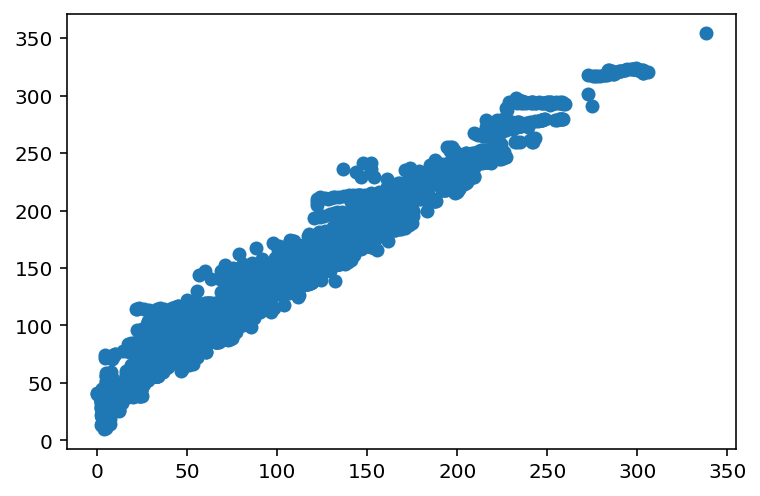

In [30]:
import matplotlib.pyplot as plt
plt.scatter(df['min_dist_PA_edge2edge'], df['min_dist_PA_centroid'])

In [31]:
a = pathlib.Path('/Users/simonvanvliet/TempData/2023-04-11-agar-pad-processed/Registration_max_frames/20230411_reg_p000-labels_SA1.h5')

In [32]:
os.remove(a)

NameError: name 'os' is not defined